# Import data

In [1]:
import os
import pandas as pd
import numpy as np

directory = './picklefiles'
# List all files that start with the specified pattern

def load_pickle_files(directory, file_pattern):
    matching_files = [file for file in os.listdir(directory) if file.startswith(file_pattern)]
    matching_files
    l = []
    for file in matching_files:
        l.append(pd.read_pickle(os.path.join(directory,file)))
    return pd.concat(l)

import pickle
posts = pickle.load(open(f'{directory}/posts_with_topic.pkl', 'rb'))
print("Posts loaded")

answers = load_pickle_files(directory, 'posts_typecasted_')
answers = answers[answers["PostTypeId"] == 2]
print("Answers loaded")

comments = pickle.load(open(f'{directory}/comments_typecasted.pkl', 'rb'))
print("Comments loaded")


Posts loaded
Answers loaded
Comments loaded


In [2]:
TAG_COUNTS = pickle.load(open(f'{directory}/tag_counts.pkl', 'rb'))
print("Tag counts loaded")
# Dictionary TOPIC -> {TAGS}
TOPIC_TAGS = pickle.load(open(f'{directory}/communities_louvain.pkl', 'rb'))
TOPIC_TAGS = [{key: value for (key,value) in topic} for topic in TOPIC_TAGS] # Convert to list of dictionaries
print("Topic tags loaded")

Tag counts loaded
Topic tags loaded


In [4]:
USERS = pickle.load(open(f'{directory}/active_users_with_sentiment.pkl', 'rb'))

# Clean data

In [5]:
def percentage_of_nan(column):
    return round(100*sum(column.isna())/len(column),2)

In [6]:
posts_mapping = dict(zip(posts['Id'], posts['ViewCount']))
answers_mapping = dict(zip(answers['Id'], answers['ViewCount']))

all_mapping = {**posts_mapping, **answers_mapping}

In [7]:
answers = answers[answers['ParentId'].map(posts_mapping).notna()]

In [8]:
comments = comments[comments['PostId'].map(all_mapping).notna()]

In [9]:
percentage_of_nan(comments['PostId'].map(all_mapping))

0.0

In [10]:
len(comments)

6435484

In [11]:
question_topic_mapping = dict(zip(posts['Id'], posts['Topic']))
answers['Topic'] = answers['ParentId'].map(question_topic_mapping)

In [12]:
answer_topic_mapping = dict(zip(answers['Id'], answers['Topic']))

posts_topic_mapping = {**question_topic_mapping, **answer_topic_mapping} 

comments['Topic'] = comments['PostId'].map(posts_topic_mapping)

In [15]:
pickle.dump(answers, open(f'{directory}/answers_clean.pkl', 'wb'))
pickle.dump(comments, open(f'{directory}/comments_clean.pkl', 'wb'))
pickle.dump(TOPIC_TAGS, open(f'{directory}/topic_tags_clean.pkl', 'wb'))

# Create new columns

## Views and ViewCount

In [13]:
post_probability = 0.5

posts_views_mapping = dict(zip(posts['Id'], posts['ViewCount']*post_probability))
answers['ViewCount'] = answers['ParentId'].map(posts_views_mapping)

In [14]:
comment_probability = 0.7
posts_views_mapping = dict(zip(posts['Id'], posts['ViewCount']*comment_probability))
answers_views_mapping = dict(zip(answers['Id'], answers['ViewCount']*comment_probability))
comments['Views'] = comments['PostId'].map({**posts_views_mapping, **answers_views_mapping})

In [ ]:
pickle.dump(answers, open(f'{directory}/answers_clean.pkl', 'wb'))
pickle.dump(comments, open(f'{directory}/comments_clean.pkl', 'wb'))

## Main topic

In [10]:
import os
import pandas as pd
import numpy as np
import pickle

directory = './picklefiles'

posts = pickle.load(open(f'{directory}/posts_with_topic.pkl', 'rb'))
print("Posts loaded")
answers = pickle.load(open(f'{directory}/answers_clean.pkl', 'rb'))
print("Answers loaded")
comments = pickle.load(open(f'{directory}/comments_clean.pkl', 'rb'))
print("Comments loaded")
TOPIC_TAGS = pickle.load(open(f'{directory}/topic_tags_clean.pkl', 'rb'))
print("Topic tags loaded")
TAG_COUNTS = pickle.load(open(f'{directory}/tag_counts.pkl', 'rb'))
print("Tag counts loaded")
USERS = pickle.load(open(f'{directory}/active_users_with_sentiment.pkl', 'rb'))

Posts loaded
Answers loaded
Comments loaded
Topic tags loaded
Tag counts loaded


Building a dictionary that links each tag to their corresponding topic.

In [4]:
def find_topic(tag):
    for i, topic in enumerate(TOPIC_TAGS):
        if tag in topic:
            return i
    return None

# Dictionary TAG -> TOPIC
TAG_TOPICS = {tag: find_topic(tag) for tag in TAG_COUNTS}
print("Tag topics built")

Tag topics built


Get main topic for a post (the topic that we will consider to analyze the post). We follow this criteria:
1. The main topic is the one with the most amount of tags.
2. If there are more than one, the tags with less instances gets picked.

In [8]:
def get_main_topic(row, verbosity = 0):
    topic_tag_counts = row["Topic"]    
    max_tag = max(topic_tag_counts)
    count_max = sum(1 for el2 in [el == max_tag for el in topic_tag_counts] if el2)
    if verbosity > 0:
        print(f"Max: {max_tag} - Count: {count_max}")
    if count_max == 0:
        return None
    elif count_max == 1:
        return np.argmax(topic_tag_counts)
    else:
        if verbosity > 0:
            print("else")
        # WHICH TAGS ARE IN THE TOPICS THAT ARE DRAWN
        # WE SUM THE NUMBER OF TAG INSTANCES IN EACH TOPIC -> ITERATE OVER TOPIC -> ITERATE OVER TAG -> SUM -> RETURN THE TOPIC WITH THE MINIMUM VALUE
        drawn_topics = [i for (i, tag_count) in enumerate(topic_tag_counts) if tag_count == max_tag]
        topic_tag = {i: [tag for tag in row["Tags"] if tag in TOPIC_TAGS[i]] for i in drawn_topics}
        instance_count = {i: sum([TAG_COUNTS[tag] for tag in topic_tag[i]]) for i in drawn_topics}
        topic = min(instance_count, key=instance_count.get)
        return topic

In [6]:
test = {"Topic": [1,0,1,0,0,0,0,0,0,0], "Tags": ["do-while", "android"]}
get_main_topic(test)

0

In [11]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Convert the pandas DataFrame to a Dask DataFrame
dask_posts = dd.from_pandas(posts, npartitions=8) # Adjust the number of partitions based on your dataset

# Define a lambda function to be applied to each row
lambda_function = lambda row: get_main_topic(row) 

# Apply the function
# Specify meta as a list, since the function returns a list
dask_posts['MainTopic'] = dask_posts.apply(lambda_function, axis=1, meta=('MainTopic', 'object'))

# Compute the results to get back a pandas DataFrame with a progress bar
with ProgressBar():
    posts = dask_posts.compute()

[########################################] | 100% Completed | 71.25 s


In [15]:
# posts['MainTopic'] = posts.apply(lambda row : get_main_topic(row), axis=1)

Assign the topic of parent post to the answers.

In [15]:
question_maintopic_mapping = dict(zip(posts['Id'], posts['MainTopic']))
answers['MainTopic'] = answers['ParentId'].map(question_maintopic_mapping)
print("Answers topic assigned")

Answers topic assigned


Assign the topic of parent post or answer to the comments.

In [16]:
answer_maintopic_mapping = dict(zip(answers['Id'], answers['MainTopic']))

posts_topic_mapping = {**question_maintopic_mapping, **answer_maintopic_mapping} 

comments['MainTopic'] = comments['PostId'].map(posts_topic_mapping)
print("Comments topic assigned")

Comments topic assigned


## Scoring

In [12]:
def get_sentiment(sentiment, i):
    if type(sentiment) == list:
        return sentiment[i]
    else:
        return 0

In [339]:
WEIGHTS = [0.5, 0.5, 0]

posts_grouped = posts.groupby(['OwnerUserId', 'MainTopic']).agg({'Score': 'sum', 'ViewCount': 'sum', 'Id': 'size'})
answers_grouped = answers.groupby(['OwnerUserId', 'MainTopic']).agg({'Score': 'sum', 'ViewCount': 'sum', 'Id': 'size'})
comments_grouped = comments.groupby(['UserId', 'MainTopic']).agg({'Score': 'sum', 'Views': 'sum', 'Id': 'size'})

In [340]:
def scoring(topic, weights, row):
    # Retrieve data for the specific user and topic, if available
    userPosts = posts_grouped.loc[(row['Id'], topic)] if (row['Id'], topic) in posts_grouped.index else pd.Series({'Score': 0, 'ViewCount': 1, 'Id': 0})
    userAnswers = answers_grouped.loc[(row['Id'], topic)] if (row['Id'], topic) in answers_grouped.index else pd.Series({'Score': 0, 'ViewCount': 1, 'Id': 0})
    userComments = comments_grouped.loc[(row['Id'], topic)] if (row['Id'], topic) in comments_grouped.index else pd.Series({'Score': 0, 'Views': 1, 'Id': 0})
    
    # Calculate the score
    score = userAnswers['Id'] * (get_sentiment(row["AvgTopicSentiment"], topic) + 20 * userAnswers['Score'] / userAnswers['ViewCount']) * weights[0] +\
            userComments['Id'] * min(userComments['Score'] / userComments['Views'], 1) * weights[1] +\
            min(userPosts['Score'] / userPosts['ViewCount'], 1) * weights[2]

    return score

In [341]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
def use_dask(df, method, npartitions = 8):
    # Convert the pandas DataFrame to a Dask DataFrame
    dask_df = dd.from_pandas(df, npartitions=npartitions) # Adjust the number of partitions based on your dataset

    method(dask_df)
    
    # Compute the results to get back a pandas DataFrame with a progress bar
    with ProgressBar():
        temp = dask_df.compute()
    return temp

In [342]:
def calculate_score(dask_df):
    # Define a lambda function to be applied to each row
    lambda_function = lambda row: [scoring(i, WEIGHTS, row) for i, _ in enumerate(TOPIC_TAGS)]

    # Apply the function
    # Specify meta as a list, since the function returns a list
    dask_df['Score'] = dask_df.apply(lambda_function, axis=1, meta=('Score', 'object'))

In [343]:
use_dask(USERS, calculate_score)

[########################################] | 100% Completed | 273.59 s


,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,PostCount,CommentCount,AcceptedAnswerCount,...,Score_5,Score_6,Score_7,Score_8,Score_9,Score_10,Score_11,Score_12,Score_13,Score_14
0,6128789,462,2016-03-29 10:49:52.617,2023-08-29 00:00:10.917,56,15,1,31.0,32.0,0.0,...,0.000000,0.0,0.000000,0.021808,0.0,0.0,0.0,0.0,0.0,0.0
1,580346,22895,2011-01-18 17:59:01.030,2023-08-31 10:24:31.333,1122,4919,82,0.0,778.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,794606,1872,2011-06-12 08:51:06.137,2023-03-28 16:43:29.407,1171,208,432,1.0,1879.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,10637188,742,2018-11-11 18:15:38.430,2023-08-29 19:28:34.423,133,115,2,20.0,126.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1000626,6197,2011-10-18 07:44:34.317,2023-08-24 13:53:59.520,649,468,24,5.0,379.0,0.0,...,0.000000,0.0,0.012107,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11805,3135460,5277,2013-12-26 00:51:44.440,2023-06-19 02:46:05.680,409,171,14,38.0,411.0,0.0,...,0.000737,0.0,0.000040,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11806,2616735,1382,2013-07-25 01:00:55.527,2023-09-03 03:50:34.047,140,602,278,0.0,78.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11807,209863,1189,2009-11-12 18:59:14.360,2015-07-18 14:59:21.783,185,58,0,12.0,72.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11808,3750282,448,2014-06-17 21:45:20.047,2023-06-02 11:14:19.157,75,9,1,3.0,52.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [344]:
def create_score_columns(dask_df):
    for i in range(len(TOPIC_TAGS)):
        dask_df[f'Score_{i}'] = dask_df.apply(lambda row: row['Score'][i], axis=1)

In [345]:
create_score_columns(USERS)

# Results

In [346]:
def count_posts_expert_participated(experts):
    exp_comments = comments[comments['UserId'].isin(experts)]["PostId"]
    exp_answers = answers[answers['OwnerUserId'].isin(experts) | answers['Id'].isin(exp_comments)]["ParentId"]
    exp_posts = posts[posts['OwnerUserId'].isin(experts) | posts['Id'].isin(exp_answers) | posts['Id'].isin(exp_comments)]["ParentId"]
    return len(exp_posts)

In [347]:
import math
def define_experts(top = 10):
    ordered_users_by_topic = dict()
    threshold = dict()
    active_users_by_topic = dict()
    expert_candidates = dict()
    for i in range(len(TOPIC_TAGS)):
        ordered_users_by_topic[i] = USERS.sort_values(by=f"Score_{i}", ascending=False)[['Id', f"Score_{i}"]]
        active_users_by_topic[i] = ordered_users_by_topic[i][ordered_users_by_topic[i][f"Score_{i}"] > 0]
        if(len(active_users_by_topic[i]) > 0):
            threshold[i] = np.percentile(active_users_by_topic[i][f"Score_{i}"], q=(100 - top))
        else:
            threshold[i] = math.inf
        expert_candidates[i] = list(active_users_by_topic[i][active_users_by_topic[i][f"Score_{i}"] > threshold[i]]["Id"])

    flatten_experts = list(pd.Series([el for i in expert_candidates for el in expert_candidates[i] ]).unique())

    return expert_candidates, round(100*count_posts_expert_participated(flatten_experts)/count_posts_expert_participated(USERS["Id"]))

In [348]:
top_possible_values = [0,0.1, 1, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
values = []
for top in top_possible_values:
    (_, perc) = define_experts(top)
    values += [perc]

C:\Users\PC-312\AppData\Local\Temp\ipykernel_14532\2224616765.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flatten_experts = list(pd.Series([el for i in expert_candidates for el in expert_candidates[i] ]).unique())


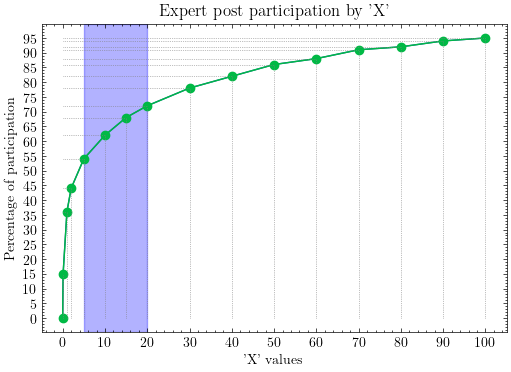

In [359]:
import matplotlib.pyplot as plt
import scienceplots
# Creating the plot
with plt.style.context('science'):
    plt.figure(figsize=(6,4))
    plt.plot(top_possible_values, values)  # Plot x vs y
    
    x = top_possible_values
    y = values

    # Creating the plot
    plt.plot(x, y, marker='o')  # Adding markers for each point

    # Adding horizontal lines from each y-point to the x-axis
    for x_val, y_val in zip(x, y):
        plt.hlines(y_val, xmin=0, xmax=x_val, linestyles='dotted', colors='grey', linewidth = 0.5)

    # Adding vertical lines from each x-point to the y-axis
    for x_val, y_val in zip(x, y):
        plt.vlines(x_val, ymin=0, ymax=y_val, linestyles='dotted', colors='grey', linewidth = 0.5)

    # Adjusting x-ticks
    x_tick_interval = 10  # Adjust this value as needed for optimal spacing
    x_ticks = np.arange(np.min(x), np.max(x) + x_tick_interval, x_tick_interval)
    plt.xticks(x_ticks)
    # Adjusting y-ticks
    y_tick_interval = 5  # Adjust this value as needed for optimal spacing
    y_ticks = np.arange(np.min(y), np.max(y) + y_tick_interval, y_tick_interval)
    plt.yticks(y_ticks)

    # Adding a transparent rectangle
    plt.axvspan(5, 20, color='blue', alpha=0.3)  # Span from x=5 to x=10


    # Adding title and labels
    plt.title("Expert post participation by 'X'")
    plt.xlabel("'X' values")
    plt.ylabel("Percentage of participation")

    # Displaying the plot
    plt.show()